In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error , mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone


#warning
import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option("display.max_columns",None)
pd.set_option("display.width",500)

In [2]:
data = pd.read_csv("heart.csv")

In [3]:
data.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.00,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.00,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.00,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.50,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.00,Up,0


In [4]:
data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [17]:
# Verinin boyutu
data.shape

(918, 12)

In [18]:
# Veri Tipleri
data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [19]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["category","object","bool"]]
    num_cat_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["int64","int32","float64","float32"]
                    and dataframe[col].nunique() < cat_th]
    cat_cols += num_cat_cols

    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtype in ["category","object"]
                   and dataframe[col].nunique() > car_th]

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["int64","float64"]
                and dataframe[col].nunique() > cat_th]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_cat_cols: {len(num_cat_cols)}")

    return cat_cols,num_cols,cat_but_car


cat_cols,num_cols,cat_but_car = grab_col_names(data)

Observations: 918
Variables: 12
cat_cols: 7
num_cols: 5
cat_but_car: 0
num_cat_cols: 2


In [20]:
# Tanımlayıcı Özet İstatistikler
data.describe([.25,0.5,0.75,1]).T

,count,mean,std,min,25%,50%,75%,100%,max
Age,918.00,53.51,9.43,28.00,47.00,54.00,60.00,77.00,77.00
RestingBP,918.00,132.40,18.51,0.00,120.00,130.00,140.00,200.00,200.00
Cholesterol,918.00,198.80,109.38,0.00,173.25,223.00,267.00,603.00,603.00
FastingBS,918.00,0.23,0.42,0.00,0.00,0.00,0.00,1.00,1.00
MaxHR,918.00,136.81,25.46,60.00,120.00,138.00,156.00,202.00,202.00
Oldpeak,918.00,0.89,1.07,-2.60,0.00,0.60,1.50,6.20,6.20
HeartDisease,918.00,0.55,0.50,0.00,0.00,1.00,1.00,1.00,1.00


In [21]:
# Kategorik Değişkenler
pd.DataFrame(cat_cols)

,0
0,Sex
1,ChestPainType
2,RestingECG
3,ExerciseAngina
4,ST_Slope
5,FastingBS
6,HeartDisease


In [22]:
# Kategorik değişkenlerin içinde kaç çeşit sınıf var ?

   Sex  Ratio
M  725  78.98
F  193  21.02
###################################


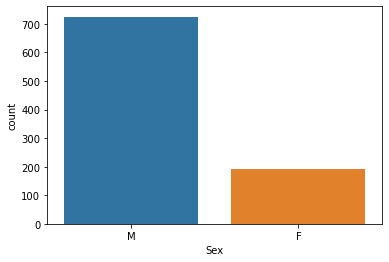

In [27]:
def cat_summary(dataframe, col_name,plot=False):
    if dataframe[col_name].dtype == 'bool':
        dataframe[col_name] = dataframe[col_name].astype(int)

    print(pd.DataFrame({col_name:data[col_name].value_counts(),
                        "Ratio":100*data[col_name].value_counts()/len(dataframe)}))
    print("###################################")

    if plot:
        sns.countplot(x=dataframe[col_name],data=dataframe)
        plt.show(block=True)

cat_summary(data,"Sex",plot=True)


     ChestPainType  Ratio
ASY            496  54.03
NAP            203  22.11
ATA            173  18.85
TA              46   5.01
###################################


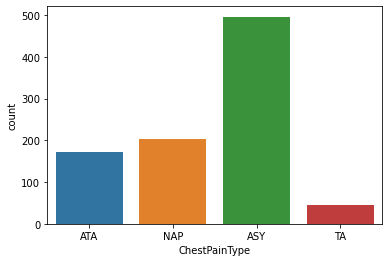

In [29]:
cat_summary(data,"ChestPainType",plot=True)


        RestingECG  Ratio
Normal         552  60.13
LVH            188  20.48
ST             178  19.39
###################################


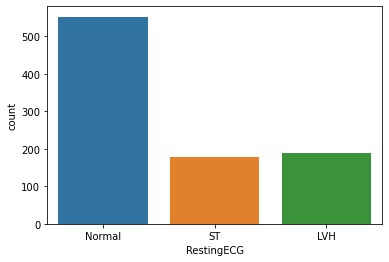

In [30]:
cat_summary(data,"RestingECG",plot=True)


   ExerciseAngina  Ratio
N             547  59.59
Y             371  40.41
###################################


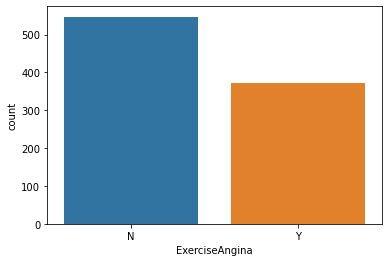

In [31]:
cat_summary(data,"ExerciseAngina",plot=True)


      ST_Slope  Ratio
Flat       460  50.11
Up         395  43.03
Down        63   6.86
###################################


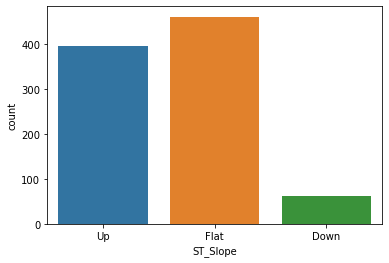

In [32]:
cat_summary(data,"ST_Slope",plot=True)


   FastingBS  Ratio
0        704  76.69
1        214  23.31
###################################


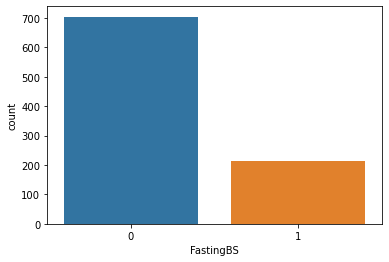

In [33]:
cat_summary(data,"FastingBS",plot=True)

   HeartDisease  Ratio
1           508  55.34
0           410  44.66
###################################


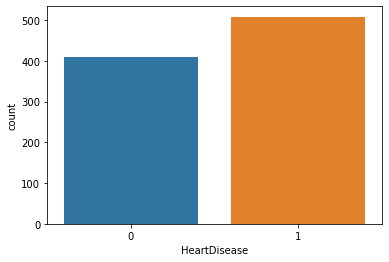

In [34]:
cat_summary(data,"HeartDisease",plot=True)

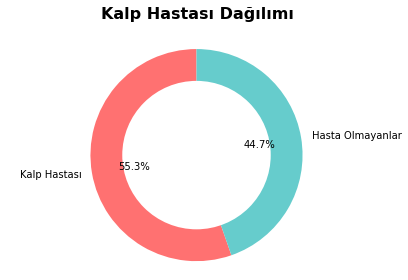

In [35]:
labels = ['Kalp Hastası', 'Hasta Olmayanlar']
heart_disease_freq = data['HeartDisease'].value_counts()
colors = ['#FF7171', '#66CCCC']
plt.pie(heart_disease_freq, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.title('Kalp Hastası Dağılımı', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

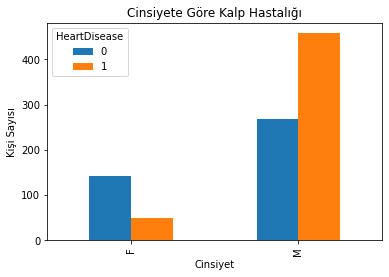

In [36]:
grouped = data.groupby(["Sex","HeartDisease"]).size().unstack()
grouped.plot(kind='bar')
plt.xlabel('Cinsiyet')
plt.ylabel('Kişi Sayısı')
plt.title('Cinsiyete Göre Kalp Hastalığı')
plt.show()

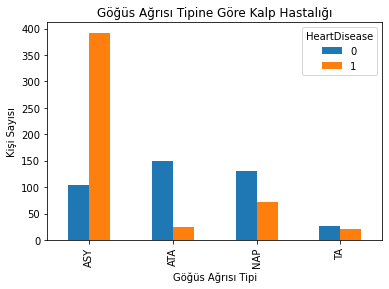

In [37]:
grouped_2 = data.groupby(["ChestPainType","HeartDisease"]).size().unstack()
grouped_2.plot(kind='bar')
plt.xlabel('Göğüs Ağrısı Tipi')
plt.ylabel('Kişi Sayısı')
plt.title('Göğüs Ağrısı Tipine Göre Kalp Hastalığı')
plt.show()

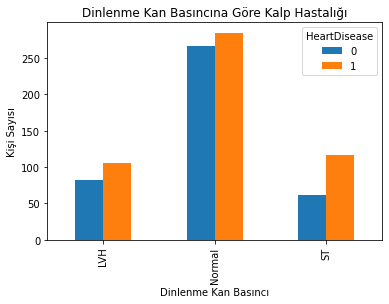

In [38]:
grouped_3 = data.groupby(["RestingECG","HeartDisease"]).size().unstack()
grouped_3.plot(kind='bar')
plt.xlabel('Dinlenme Kan Basıncı')
plt.ylabel('Kişi Sayısı')
plt.title('Dinlenme Kan Basıncına Göre Kalp Hastalığı')
plt.show()

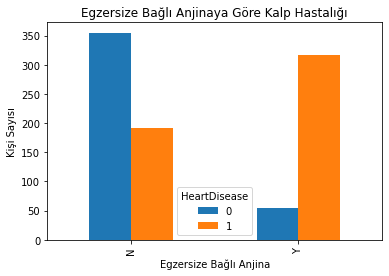

In [39]:
grouped_4 = data.groupby(["ExerciseAngina","HeartDisease"]).size().unstack()
grouped_4.plot(kind='bar')
plt.xlabel('Egzersize Bağlı Anjina')
plt.ylabel('Kişi Sayısı')
plt.title('Egzersize Bağlı Anjinaya Göre Kalp Hastalığı')
plt.show()

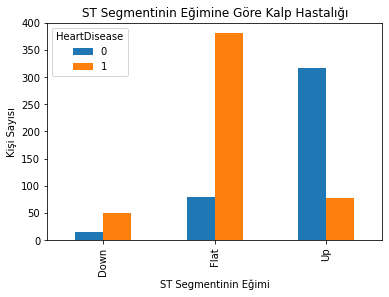

In [40]:
grouped_5 = data.groupby(["ST_Slope","HeartDisease"]).size().unstack()
grouped_5.plot(kind='bar')
plt.xlabel('ST Segmentinin Eğimi')
plt.ylabel('Kişi Sayısı')
plt.title('ST Segmentinin Eğimine Göre Kalp Hastalığı')
plt.show()

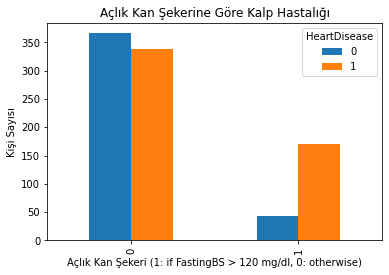

In [41]:
grouped_6 = data.groupby(["FastingBS","HeartDisease"]).size().unstack()
grouped_6.plot(kind='bar')
plt.xlabel('Açlık Kan Şekeri (1: if FastingBS > 120 mg/dl, 0: otherwise)')
plt.ylabel('Kişi Sayısı')
plt.title('Açlık Kan Şekerine Göre Kalp Hastalığı')
plt.show()

In [42]:
# Sayısal Değişkenler
pd.DataFrame(num_cols)

,0
0,Age
1,RestingBP
2,Cholesterol
3,MaxHR
4,Oldpeak


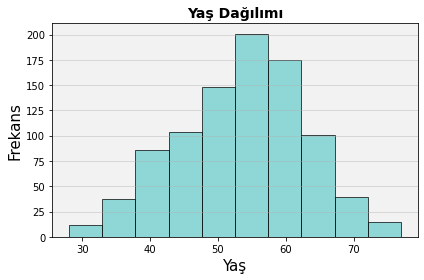

In [43]:
plt.hist(data['Age'], bins=10, edgecolor='black', color='#66CCCC', alpha=0.7)
plt.xlabel('Yaş', fontsize=15)
plt.ylabel('Frekans', fontsize=15)
plt.title('Yaş Dağılımı', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.5)
plt.gca().set_facecolor('#F2F2F2')
plt.tight_layout()
plt.show()

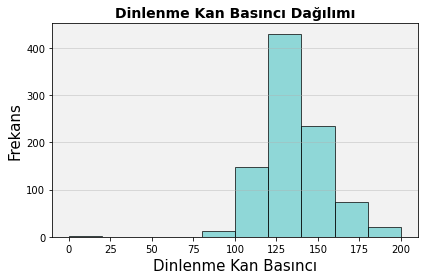

In [44]:
plt.hist(data['RestingBP'], bins=10, edgecolor='black', color='#66CCCC', alpha=0.7)
plt.xlabel('Dinlenme Kan Basıncı', fontsize=15)
plt.ylabel('Frekans', fontsize=15)
plt.title('Dinlenme Kan Basıncı Dağılımı', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.5)
plt.gca().set_facecolor('#F2F2F2')
plt.tight_layout()
plt.show()

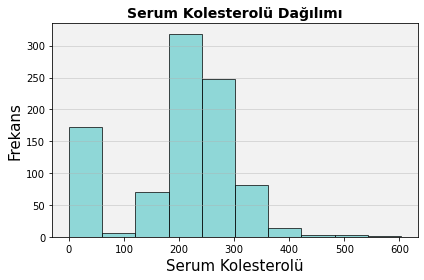

In [45]:
plt.hist(data['Cholesterol'], bins=10, edgecolor='black', color='#66CCCC', alpha=0.7)
plt.xlabel('Serum Kolesterolü', fontsize=15)
plt.ylabel('Frekans', fontsize=15)
plt.title('Serum Kolesterolü Dağılımı', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.5)
plt.gca().set_facecolor('#F2F2F2')
plt.tight_layout()
plt.show()

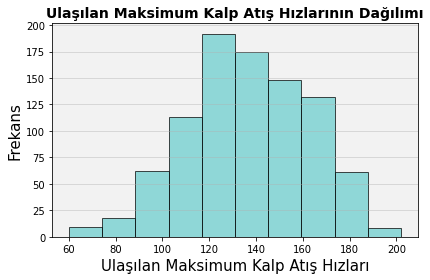

In [46]:
plt.hist(data['MaxHR'], bins=10, edgecolor='black', color='#66CCCC', alpha=0.7)
plt.xlabel('Ulaşılan Maksimum Kalp Atış Hızları', fontsize=15)
plt.ylabel('Frekans', fontsize=15)
plt.title('Ulaşılan Maksimum Kalp Atış Hızlarının Dağılımı', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.5)
plt.gca().set_facecolor('#F2F2F2')
plt.tight_layout()
plt.show()

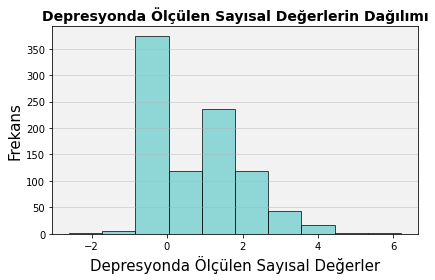

In [47]:
plt.hist(data['Oldpeak'], bins=10, edgecolor='black', color='#66CCCC', alpha=0.7)
plt.xlabel('Depresyonda Ölçülen Sayısal Değerler', fontsize=15)
plt.ylabel('Frekans', fontsize=15)
plt.title('Depresyonda Ölçülen Sayısal Değerlerin Dağılımı', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.5)
plt.gca().set_facecolor('#F2F2F2')
plt.tight_layout()
plt.show()

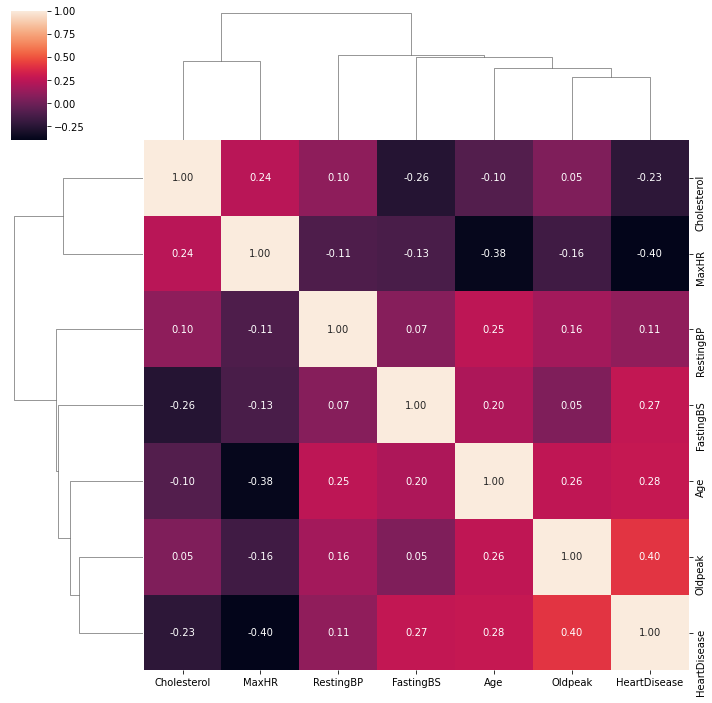

In [48]:
corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot=True, fmt = ".2f")
plt.show()

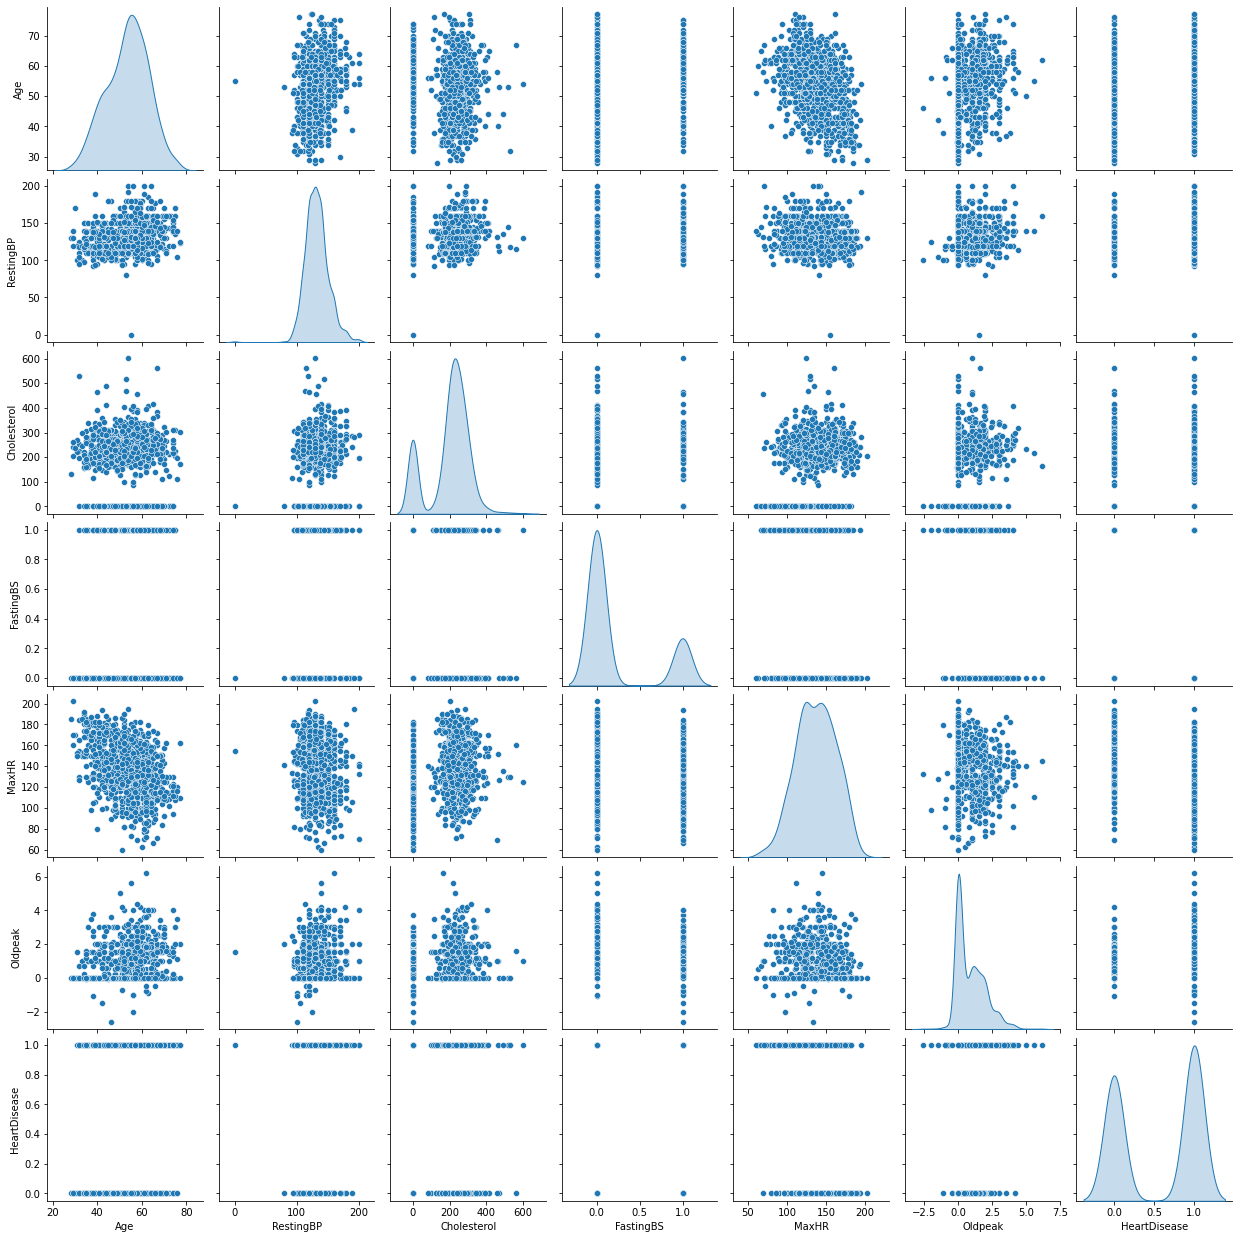

In [49]:
sns.pairplot(data, diag_kind="kde")
plt.show()

# Outlier Detection

In [50]:
# Threshold setting function
def outlier_thresholds(dataframe,col_name,q1=0.25,q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    iqr = quartile3 - quartile1
    low_limit = quartile1 - 1.5*iqr
    up_limit = quartile3 + 1.5*iqr
    return low_limit,up_limit

In [51]:
# Is there an outlier or not?
def check_outlier(dataframe,col_name):
    low,up = outlier_thresholds(dataframe,col_name)
    if dataframe[(dataframe[col_name] < low) | (dataframe[col_name]>up)].any(axis=None):
        return True
    else:
        return False

In [52]:
for col in num_cols:
    print(col,":",check_outlier(data,col))

Age : False
RestingBP : True
Cholesterol : True
MaxHR : True
Oldpeak : True


In [134]:
# Which observations outlier ?
def grab_outliers(dataframe,col,index=False):
    low,up = outlier_thresholds(dataframe,col)
    if not dataframe[(dataframe[col] < low) | (dataframe[col] > up)].any(axis=None):
        print("There is no outlier")
        return 0
    if dataframe[(dataframe[col] < low) | (dataframe[col] > up)].shape[0] > 10:
        print(dataframe[(dataframe[col] < low) | (dataframe[col] > up)].head())
    else:
        print(dataframe[(dataframe[col] < low) | (dataframe[col] > up)])
    if index:
        return dataframe[(dataframe[col] < low) | (dataframe[col] > up)].index

In [135]:
grab_outliers(data,"RestingBP")

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease
109   39   M           ATA        190          241          0     Normal    106              N     0.00       Up             0
123   58   F           ATA        180          393          0     Normal    110              Y     1.00     Flat             1
189   53   M           ASY        180          285          0         ST    120              Y     1.50     Flat             1
190   46   M           ASY        180          280          0         ST    120              N     0.00       Up             0
241   54   M           ASY        200          198          0     Normal    142              Y     2.00     Flat             1


In [136]:
grab_outliers(data,"Cholesterol")

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease
28    53   F           ATA        113          468          0     Normal    127              N     0.00       Up             0
30    53   M           NAP        145          518          0     Normal    130              N     0.00     Flat             1
69    44   M           ASY        150          412          0     Normal    170              N     0.00       Up             0
76    32   M           ASY        118          529          0     Normal    130              N     0.00     Flat             1
103   40   M           ASY        120          466          1     Normal    152              Y     1.00     Flat             1


In [137]:
grab_outliers(data,"MaxHR")

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease
370   60   M           ASY        135            0          0     Normal     63              Y     0.50       Up             1
390   51   M           ASY        140            0          0     Normal     60              N     0.00     Flat             1


In [138]:
grab_outliers(data,"Oldpeak")

     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease
68    52   M           ASY        160          246          0         ST     82              Y     4.00     Flat             1
166   50   M           ASY        140          231          0         ST    140              Y     5.00     Flat             1
324   46   M           ASY        100            0          1         ST    133              N    -2.60     Flat             1
500   65   M           ASY        136          248          0     Normal    140              Y     4.00     Down             1
521   61   M           ASY        120          282          0         ST    135              Y     4.00     Down             1


# Normallik testi

In [139]:
# Sayısal Değişkenler
pd.DataFrame(num_cols)

,0
0,Age
1,RestingBP
2,Cholesterol
3,MaxHR
4,Oldpeak


In [140]:
from scipy.stats import shapiro
df = pd.DataFrame(data)

# Çoklu normallik testi
for column in num_cols:
    if column != 'Sex':
        statistic, p_value = shapiro(df[column])
        print(f'{column}:')
        print(f'Statistic: {statistic:.4f}')
        print(f'p-value: {p_value:.4f}')
        if p_value > 0.05:
            print('Dağılım normaldir.')
        else:
            print('Dağılım normal değildir.')
        print('-------------------------')

Age:
Statistic: 0.9910
p-value: 0.0000
Dağılım normal değildir.
-------------------------
RestingBP:
Statistic: 0.9580
p-value: 0.0000
Dağılım normal değildir.
-------------------------
Cholesterol:
Statistic: 0.8706
p-value: 0.0000
Dağılım normal değildir.
-------------------------
MaxHR:
Statistic: 0.9927
p-value: 0.0002
Dağılım normal değildir.
-------------------------
Oldpeak:
Statistic: 0.8599
p-value: 0.0000
Dağılım normal değildir.
-------------------------


In [141]:
# Veri normal dağılmıyor. Outlierlar Lojistik regresyon modeli kurulduktan sonra çıkarılacak.
# 2. Bir Alternatif lojistik regresyon modeli için outlierlar çıkarılacak normallik varsayımı kontrol edilecek.

In [142]:
df = pd.DataFrame(data)

# Çoklu normallik testi
for column in num_cols:
    if column != 'Sex':
        statistic, p_value = shapiro(df[column])
        print(f'{column}:')
        print(f'Statistic: {statistic:.4f}')
        print(f'p-value: {p_value:.4f}')
        if p_value > 0.05:
            print('Dağılım normaldir.')
        else:
            print('Dağılım normal değildir.')
        print('-------------------------')

Age:
Statistic: 0.9910
p-value: 0.0000
Dağılım normal değildir.
-------------------------
RestingBP:
Statistic: 0.9580
p-value: 0.0000
Dağılım normal değildir.
-------------------------
Cholesterol:
Statistic: 0.8706
p-value: 0.0000
Dağılım normal değildir.
-------------------------
MaxHR:
Statistic: 0.9927
p-value: 0.0002
Dağılım normal değildir.
-------------------------
Oldpeak:
Statistic: 0.8599
p-value: 0.0000
Dağılım normal değildir.
-------------------------


In [143]:
# Veri seti outlierların çıkarılmasına rağmen normal dağılmıyor

In [144]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


In [145]:
data.shape

(918, 12)

# Ki-Kare Testleri

In [149]:
# Kategorik değişkenler
pd.DataFrame(cat_cols)

,0
0,Sex
1,ChestPainType
2,RestingECG
3,ExerciseAngina
4,ST_Slope
5,FastingBS
6,HeartDisease


In [150]:
from scipy.stats import chi2_contingency

In [151]:
def chi2_test(data, var1, var2):
    contingency_table = pd.crosstab(data[var1], data[var2])
    statistic, p_value, _, _ = chi2_contingency(contingency_table)
    return statistic, p_value

In [152]:
var1 = 'Sex'
var2 = 'HeartDisease'

statistic, p_value = chi2_test(data, var1, var2)

print(f'{var1} ve {var2} arasındaki Ki-Kare Testi sonuçları:')
print("------------------------------------------------")

print(f'Statistic: {statistic:.4f}')
print(f'p-value: {p_value:.4f}')
print("------------------------------------------------")
print("Cinsiyet ve kalp hastalığı arasında bir ilişki bulunmaktadır.")

Sex ve HeartDisease arasındaki Ki-Kare Testi sonuçları:
------------------------------------------------
Statistic: 84.1451
p-value: 0.0000
------------------------------------------------
Cinsiyet ve kalp hastalığı arasında bir ilişki bulunmaktadır.


In [153]:
##############################################################

In [154]:
var1 = 'ChestPainType'
var2 = 'HeartDisease'

statistic, p_value = chi2_test(data, var1, var2)

print(f'{var1} ve {var2} arasındaki Ki-Kare Testi sonuçları:')
print("------------------------------------------------")

print(f'Statistic: {statistic:.4f}')
print(f'p-value: {p_value:.4f}')
print("------------------------------------------------")
print("Göğüs ağrısı türü ve kalp hastalığı arasında bir ilişki bulunmaktadır.")

ChestPainType ve HeartDisease arasındaki Ki-Kare Testi sonuçları:
------------------------------------------------
Statistic: 268.0672
p-value: 0.0000
------------------------------------------------
Göğüs ağrısı türü ve kalp hastalığı arasında bir ilişki bulunmaktadır.


In [155]:
##############################################################

In [156]:
var1 = 'RestingECG'
var2 = 'HeartDisease'

statistic, p_value = chi2_test(data, var1, var2)

print(f'{var1} ve {var2} arasındaki Ki-Kare Testi sonuçları:')
print("------------------------------------------------")

print(f'Statistic: {statistic:.4f}')
print(f'p-value: {p_value:.4f}')
print("------------------------------------------------")
print("İstirahat elektrokardiyogram sonuçları ile kalp hastalığı türü arasında bir ilişki bulunmaktadır.")

RestingECG ve HeartDisease arasındaki Ki-Kare Testi sonuçları:
------------------------------------------------
Statistic: 10.9315
p-value: 0.0042
------------------------------------------------
İstirahat elektrokardiyogram sonuçları ile kalp hastalığı türü arasında bir ilişki bulunmaktadır.


In [157]:
##############################################################

In [158]:
var1 = 'ST_Slope'
var2 = 'HeartDisease'

statistic, p_value = chi2_test(data, var1, var2)

print(f'{var1} ve {var2} arasındaki Ki-Kare Testi sonuçları:')
print("------------------------------------------------")

print(f'Statistic: {statistic:.4f}')
print(f'p-value: {p_value:.4f}')
print("------------------------------------------------")
print("ST segmenti ile kalp hastalığı türü arasında bir ilişki bulunmaktadır.")

ST_Slope ve HeartDisease arasındaki Ki-Kare Testi sonuçları:
------------------------------------------------
Statistic: 355.9184
p-value: 0.0000
------------------------------------------------
ST segmenti ile kalp hastalığı türü arasında bir ilişki bulunmaktadır.


In [159]:
##############################################################

In [160]:
var1 = 'ST_Slope'
var2 = 'HeartDisease'

statistic, p_value = chi2_test(data, var1, var2)

print(f'{var1} ve {var2} arasındaki Ki-Kare Testi sonuçları:')
print("------------------------------------------------")

print(f'Statistic: {statistic:.4f}')
print(f'p-value: {p_value:.4f}')
print("------------------------------------------------")
print("ST segmenti ile kalp hastalığı türü arasında bir ilişki bulunmaktadır.")

ST_Slope ve HeartDisease arasındaki Ki-Kare Testi sonuçları:
------------------------------------------------
Statistic: 355.9184
p-value: 0.0000
------------------------------------------------
ST segmenti ile kalp hastalığı türü arasında bir ilişki bulunmaktadır.


In [161]:
##############################################################

In [162]:
var1 = 'FastingBS'
var2 = 'HeartDisease'

statistic, p_value = chi2_test(data, var1, var2)

print(f'{var1} ve {var2} arasındaki Ki-Kare Testi sonuçları:')
print("------------------------------------------------")

print(f'Statistic: {statistic:.4f}')
print(f'p-value: {p_value:.4f}')
print("------------------------------------------------")
print("Açlık kan şekeri ile kalp hastalığı türü arasında bir ilişki bulunmaktadır.")

FastingBS ve HeartDisease arasındaki Ki-Kare Testi sonuçları:
------------------------------------------------
Statistic: 64.3207
p-value: 0.0000
------------------------------------------------
Açlık kan şekeri ile kalp hastalığı türü arasında bir ilişki bulunmaktadır.


# Lojistik Regresyon Modeli

### Model 1

In [163]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

In [164]:
# Veriyi model için hazırlama aşaması

In [166]:
data_2 = data.copy()

In [167]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


In [168]:
cat_cols

['Sex',
 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope',
 'FastingBS',
 'HeartDisease']

In [169]:
# Kategorik değişkenlerin sınıflarının sayısal değerlere dönüştürülmesi
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])
data['ChestPainType'] = label_encoder.fit_transform(data['ChestPainType'])
data['FastingBS'] = label_encoder.fit_transform(data['FastingBS'])
data['RestingECG'] = label_encoder.fit_transform(data['RestingECG'])
data['ExerciseAngina'] = label_encoder.fit_transform(data['ExerciseAngina'])
data['ST_Slope'] = label_encoder.fit_transform(data['ST_Slope'])
data['HeartDisease'] = label_encoder.fit_transform(data['HeartDisease'])

In [170]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.00,2,0
1,49,0,2,160,180,0,1,156,0,1.00,1,1
2,37,1,1,130,283,0,2,98,0,0.00,2,0
3,48,0,0,138,214,0,1,108,1,1.50,1,1
4,54,1,2,150,195,0,1,122,0,0.00,2,0


In [171]:
# test - train
x = data.drop(["HeartDisease"],axis=1)
y = data["HeartDisease"]
test_size=0.3
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=test_size, random_state = 35)

In [172]:
# Model Fiting
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [173]:
y_pred = model.predict(x_test)

In [174]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8514492753623188


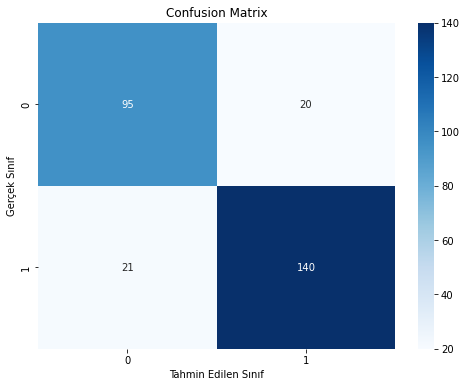

In [175]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.show()

In [176]:
from sklearn.metrics import classification_report
classification_rep = classification_report(y_test, y_pred)
print("Sınıflandırma Raporu:")
print(classification_rep)

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       115
           1       0.88      0.87      0.87       161

    accuracy                           0.85       276
   macro avg       0.85      0.85      0.85       276
weighted avg       0.85      0.85      0.85       276



In [177]:
# Katsayıları ve oranlar
coefficients = model.coef_[0]
odds_ratios = np.exp(coefficients)


In [178]:
for i, coefficient in enumerate(coefficients):
    print("Öznitelik {}: Katsayı = {:.4f}, Odds_Ratio = {:.4f}".format(i+1, coefficient, odds_ratios[i]))

Öznitelik 1: Katsayı = 0.0279, Odds_Ratio = 1.0283
Öznitelik 2: Katsayı = 1.1559, Odds_Ratio = 3.1768
Öznitelik 3: Katsayı = -0.5775, Odds_Ratio = 0.5613
Öznitelik 4: Katsayı = 0.0084, Odds_Ratio = 1.0084
Öznitelik 5: Katsayı = -0.0033, Odds_Ratio = 0.9967
Öznitelik 6: Katsayı = 0.8338, Odds_Ratio = 2.3021
Öznitelik 7: Katsayı = 0.0381, Odds_Ratio = 1.0388
Öznitelik 8: Katsayı = -0.0059, Odds_Ratio = 0.9942
Öznitelik 9: Katsayı = 1.0892, Odds_Ratio = 2.9720
Öznitelik 10: Katsayı = 0.2961, Odds_Ratio = 1.3447
Öznitelik 11: Katsayı = -1.7268, Odds_Ratio = 0.1779


In [179]:
# Katsayılar, ilgili özniteliğin hedef değişken üzerindeki etkisini temsil ederken, 
# oranlar, ilgili özniteliğin hedef değişkenin olasılık oranları üzerindeki etkisini yansıtır. 
# Yorumlar yaparken, katsayıların işaretine (pozitif veya negatif) ve oranların değerine dikkat etmek önemlidir.

In [180]:
# Test veri kümesi üzerinde tahmin probabliliklerini alındı.
y_probs = model.predict_proba(x_test)[:, 1]

# ROC eğrisi için false positive oranı (FPR), true positive oranı (TPR) ve eşik değerleri hesaplandı.
fpr, tpr, thresholds = roc_curve(y_test, y_probs)


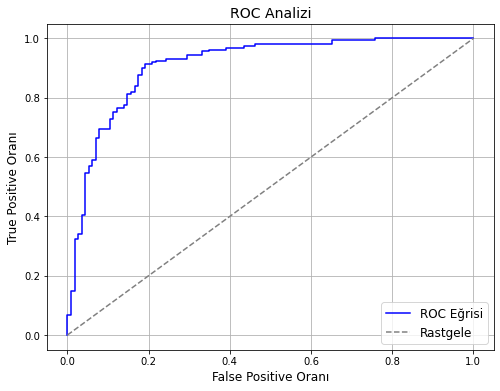

In [181]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label='ROC Eğrisi')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Rastgele')
plt.xlabel('False Positive Oranı', fontsize=12)
plt.ylabel('True Positive Oranı', fontsize=12)
plt.title('ROC Analizi', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [182]:
auc = roc_auc_score(y_test, y_probs)
print("AUC Değeri:", auc)

AUC Değeri: 0.9102349446394815


In [183]:
# Kesim noktasını belirlendi
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Kesim Noktası (Eşik Değeri):", optimal_threshold)

Kesim Noktası (Eşik Değeri): 0.43996158821395065


In [184]:
# deney birimi için tahmin edilen olasılıklar
predicted_prob = model.predict_proba(x_test)[:, 1]
print("Tahmin Edilen Olasılık:", predicted_prob)

Tahmin Edilen Olasılık: [0.05978403 0.23445427 0.06698126 0.4789957  0.69240567 0.21753711
 0.2525247  0.54417921 0.53203124 0.88051533 0.83239495 0.16925188
 0.34662528 0.76460628 0.92755997 0.03283671 0.09706165 0.22078213
 0.45596464 0.71655196 0.79789057 0.91325073 0.85107533 0.03314305
 0.65052008 0.11784442 0.78661431 0.56325654 0.05337831 0.12005542
 0.8586346  0.03296663 0.05021251 0.97155733 0.10439078 0.91970459
 0.9012052  0.09033819 0.92749727 0.74730034 0.3532235  0.58974145
 0.04245857 0.44952075 0.95551161 0.62745252 0.13633775 0.08791978
 0.22184135 0.97001876 0.89540939 0.92153978 0.07456609 0.1140733
 0.04016991 0.83600905 0.86012761 0.8576875  0.91100948 0.43996159
 0.55979661 0.9505409  0.74366902 0.87412568 0.96498184 0.1146234
 0.09582396 0.93355266 0.70812564 0.03732779 0.07084209 0.18570074
 0.32151583 0.74864477 0.60996074 0.98504019 0.97669386 0.14537566
 0.09906166 0.46253758 0.03765655 0.1902242  0.67880412 0.68733194
 0.5200836  0.82645112 0.84563959 0.4675

### Model 2

In [185]:
# Bu modelde veriden outlierlar çıkarılacak. Daha sonra modelleme yapılacaktır.

In [186]:
# Removing outliers
def remove_outlier(dataframe,col):
    low,up = outlier_thresholds(dataframe,col)
    data_without_outliers = dataframe[~((data_2[col] < low) | (data_2[col]>up))]
    return data_without_outliers 

data_2 = remove_outlier(data_2,"RestingBP")
data_2 = remove_outlier(data_2,"Cholesterol")
data_2 = remove_outlier(data_2,"MaxHR")
data_2 = remove_outlier(data_2,"Oldpeak")

In [187]:
data_2.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


In [189]:
# Kategorik değişkenlerin sınıflarının sayısal değerlere dönüştürülmesi.
# Veri model için hazırlanıyor.
label_encoder = LabelEncoder()
data_2['Sex'] = label_encoder.fit_transform(data_2['Sex'])
data_2['ChestPainType'] = label_encoder.fit_transform(data_2['ChestPainType'])
data_2['FastingBS'] = label_encoder.fit_transform(data_2['FastingBS'])
data_2['RestingECG'] = label_encoder.fit_transform(data_2['RestingECG'])
data_2['ExerciseAngina'] = label_encoder.fit_transform(data_2['ExerciseAngina'])
data_2['ST_Slope'] = label_encoder.fit_transform(data_2['ST_Slope'])
data_2['HeartDisease'] = label_encoder.fit_transform(data_2['HeartDisease'])

In [190]:
data_2.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.00,2,0
1,49,0,2,160,180,0,1,156,0,1.00,1,1
2,37,1,1,130,283,0,2,98,0,0.00,2,0
3,48,0,0,138,214,0,1,108,1,1.50,1,1
4,54,1,2,150,195,0,1,122,0,0.00,2,0


In [191]:
# test - train
x = data_2.drop(["HeartDisease"],axis=1)
y = data_2["HeartDisease"]
test_size=0.3
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=test_size, random_state = 35)

In [192]:
# Model Fiting
model_2 = LogisticRegression()
model_2.fit(x_train, y_train)

LogisticRegression()

In [193]:
y_pred_2 = model.predict(x_test)

In [195]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_2)
print("Accuracy:", accuracy)

Accuracy: 0.8672985781990521


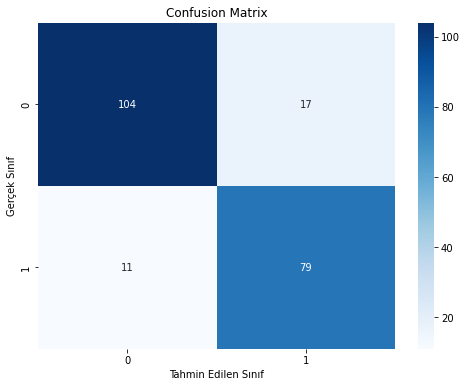

In [196]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.show()

In [197]:
from sklearn.metrics import classification_report
classification_rep = classification_report(y_test, y_pred_2)
print("Sınıflandırma Raporu:")
print(classification_rep)

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       121
           1       0.82      0.88      0.85        90

    accuracy                           0.87       211
   macro avg       0.86      0.87      0.87       211
weighted avg       0.87      0.87      0.87       211



In [198]:
# Katsayıları ve oranlar
coefficients_2 = model_2.coef_[0]
odds_ratios_2 = np.exp(coefficients_2)

In [201]:
for i, coefficients_2 in enumerate(coefficients_2):
    print("Öznitelik {}: Katsayı = {:.4f}, Odds_Ratio = {:.4f}".
          format(i+1, coefficients_2, odds_ratios_2[i]))

Öznitelik 1: Katsayı = 0.0276, Odds_Ratio = 1.0280
Öznitelik 2: Katsayı = 1.5026, Odds_Ratio = 4.4933
Öznitelik 3: Katsayı = -0.6910, Odds_Ratio = 0.5011
Öznitelik 4: Katsayı = 0.0045, Odds_Ratio = 1.0045
Öznitelik 5: Katsayı = 0.0021, Odds_Ratio = 1.0021
Öznitelik 6: Katsayı = 0.2151, Odds_Ratio = 1.2400
Öznitelik 7: Katsayı = -0.2295, Odds_Ratio = 0.7949
Öznitelik 8: Katsayı = -0.0081, Odds_Ratio = 0.9919
Öznitelik 9: Katsayı = 0.8540, Odds_Ratio = 2.3491
Öznitelik 10: Katsayı = 0.4522, Odds_Ratio = 1.5717
Öznitelik 11: Katsayı = -1.7424, Odds_Ratio = 0.1751


In [202]:
# Katsayılar, ilgili özniteliğin hedef değişken üzerindeki etkisini temsil ederken, 
# oranlar, ilgili özniteliğin hedef değişkenin olasılık oranları üzerindeki etkisini yansıtır. 
# Yorumlar yaparken, katsayıların işaretine (pozitif veya negatif) ve oranların değerine dikkat etmek önemlidir.

In [203]:
# Test veri kümesi üzerinde tahmin probabliliklerini alındı.
y_probs = model_2.predict_proba(x_test)[:, 1]

# ROC eğrisi için false positive oranı (FPR), true positive oranı (TPR) ve eşik değerleri hesaplandı.
fpr, tpr, thresholds = roc_curve(y_test, y_probs)


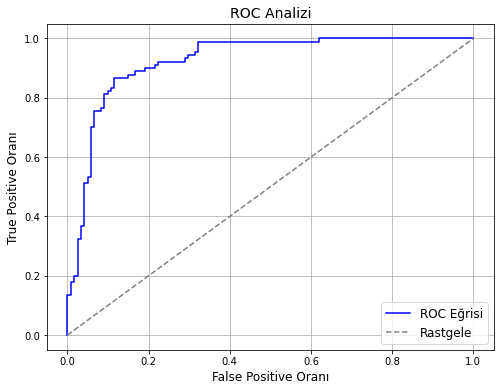

In [204]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label='ROC Eğrisi')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Rastgele')
plt.xlabel('False Positive Oranı', fontsize=12)
plt.ylabel('True Positive Oranı', fontsize=12)
plt.title('ROC Analizi', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [205]:
auc = roc_auc_score(y_test, y_probs)
print("AUC Değeri:", auc)

AUC Değeri: 0.9251606978879706


In [206]:
# Kesim noktası belirlendi
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Kesim Noktası (Eşik Değeri):", optimal_threshold)

Kesim Noktası (Eşik Değeri): 0.5950979350640251


In [207]:
# deney birimi için tahmin edilen olasılıklar
predicted_prob = model_2.predict_proba(x_test)[:, 1]
print("Tahmin Edilen Olasılık:", predicted_prob)

Tahmin Edilen Olasılık: [0.35354874 0.13011752 0.95703737 0.50918809 0.21160082 0.38017705
 0.02314908 0.91120232 0.01765733 0.06311012 0.03026861 0.70554061
 0.20593679 0.07407667 0.93929227 0.06491415 0.89679972 0.94190402
 0.93922313 0.86708243 0.8205085  0.14580408 0.29227847 0.78987717
 0.69351838 0.25989075 0.61483694 0.02247439 0.02461442 0.90159647
 0.59509794 0.0300095  0.27359192 0.95192795 0.97066509 0.01984032
 0.32380002 0.71197917 0.33368973 0.27802039 0.07725625 0.8014918
 0.44913733 0.15793823 0.0152467  0.91617934 0.95099586 0.08905165
 0.18447226 0.9432442  0.07865927 0.28495547 0.94822192 0.14633538
 0.95757438 0.04055565 0.30507472 0.44926578 0.69212378 0.02362203
 0.91509524 0.30443603 0.13898032 0.12950542 0.8673017  0.71966839
 0.70173458 0.50015741 0.07204629 0.92715401 0.01519618 0.86618367
 0.63189564 0.30587242 0.40255208 0.83915785 0.29693253 0.94104688
 0.17649424 0.11107112 0.70785808 0.04868059 0.93248082 0.04899201
 0.73520653 0.99537063 0.84715777 0.215

# Missing Value